# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> Eedi - Mining Misconceptions in Mathematics</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Predict affinity between misconceptions and incorrect answers (distractors) in multiple-choice questions </center></p>


# Overview

> In this competition, you’ll develop an **NLP model** driven by ML to accurately predict the **affinity between misconceptions and incorrect answers (distractors) in multiple-choice questions**. This solution will suugest candidate misconceptions for distractors, making it easier for expert **human teachers to tag distractors with misconceptions.**

**Our task** : 
* Create a model able to determine the **correct answer first from a Multiple Choice Question**
* Then it has to understand **what the other incorrect options are there for**. Usually for math MCQs, the other options are there to **confuse the answerer**, there could be some misconceptions that lead to an incorrect answer, which is often the case for math MCQs. You do the math wrong, yet you find your wrong answer available among the four options. The models task is to understand **what kind of misconception leads to the specific incorrect option**

Let's start with an example.

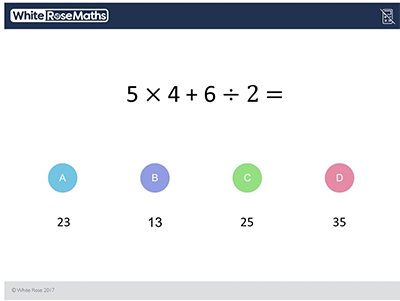

In this example, the options for the question are labeled with misconceptions as follows:

- **A** - Correct (no distractor)
- **B** - Carries out operations from left to right regardless of priority order
- **C** - Confuses the order of operations, believes addition comes before division
- **D** - Confuses the order of operations, believes addition comes before multiplication
The Diagnostic Questions were originally presented in image format, and the text, including mathematical content, has been extracted using a human-in-the-loop OCR process.

**File and Field Information**

- **[train/test].csv**

- - `QuestionId` - Unique question identifier (`int`).
- - `ConstructId` - Unique construct identifier (`int`) .
- - `ConstructName` - Most granular level of knowledge related to question (`str`).
- - `CorrectAnswer` - A, B, C or D (`char`).
- - `SubjectId` - Unique subject identifier (`int`).
- - `SubjectName` - More general context than the construct (`str`).
- - `QuestionText` - Question text extracted from the question image using human-in-the-loop OCR (`str`) .
- - `Answer[A/B/C/D]Text` - Answer option A text extracted from the question image using human-in-the-loop OCR (`str`).
- - `Misconception[A/B/C/D]Id` - Unique misconception identifier (`int`). Ground truth labels in `train.csv`; your task is to predict these labels for `test.csv`.
- **misconception_mapping.csv** - maps MisconceptionId to its MisconceptionName
- **sample_submission.csv** - A submission file in the correct format.
- - `QuestionId_Answer` - Each question has three incorrect answers for which need you predict the `MisconceptionId`.
- - `MisconceptionId` - You can predict up to 25 values, space delimited.

# 📚 Importing Libraries

In [ ]:
# Importing essential libraries
import numpy as np  # For numerical computations
import pandas as pd  # For handling data in DataFrames
import random  # To set random seed for reproducibility
import os  # Operating system dependent functionalities

# Set random seed for reproducibility
random.seed(10)

# Import scikit-learn utilities for cross-validation and feature extraction
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold  # Different cross-validation strategies
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text data into numerical form using TF-IDF

# Import machine learning models
import lightgbm as lgb  # LightGBM, a gradient boosting framework
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.svm import SVC  # Support Vector Classifier

# Progress bar for loops
from tqdm import tqdm  # Progress bar utility for monitoring long-running operations

# Joblib for saving and loading models
import joblib  # For model persistence (save/load models)

# Import metrics for evaluating model performance
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_absolute_percentage_error  # Model performance metrics

# Collections module for counting and creating default dictionaries
from collections import defaultdict, Counter  # Useful data structures

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings to keep the notebook clean

# Pandas settings to ensure we can view all columns and rows in large DataFrames
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



# ⚙️ Configuration Class

In [ ]:
class ConfigManager:
    OUTPUT_DIR: str = '/kaggle/working'

# 🛠️ Utility Functions for Model Inference

In [ ]:
def map25(true_ids: tuple[int], predictions: list[int]) -> float:
    """
    Calculate precision at 25 for the given true misconception IDs and predicted IDs.
    
    Args:
    true_ids (Tuple[int]): Tuple of true misconception IDs.
    predictions (List[int]): List of predicted misconception IDs.
    
    Returns:
    float: Precision at 25 for the prediction set.
    """
    for i, pred in enumerate(predictions[:25]):
        if pred in true_ids:
            return 1 / (i + 1)
    return 0 # Return 0 if no match within the top 25

def get_sorted_predictions(df_values: pd.DataFrame) -> np.ndarray:
    """
    Sorts the misconception candidates by their prediction scores (y_pred) in decreasing order and returns the top 25.
    
    Args:
    df_values (pd.DataFrame): DataFrame containing 'y_pred' and 'Misconception_candidate'.
    
    Returns:
    np.ndarray: Sorted array of top 25 misconception candidates.
    """
        
    # Sort values by y_pred (decreasing order)
    return df_values.sort_values(by=['y_pred'], ascending=False)['Misconception_candidate'].values[:25]

def get_sorted_predictions_for_submission(df_values: pd.DataFrame) -> str:
    """
    Sorts the misconception candidates by prediction score for submission.
    
    Args:
    df_values (pd.DataFrame): DataFrame containing 'y_pred' and 'Misconception_candidate'.
    
    Returns:
    str: Space-separated string of the top 25 misconception candidates for submission.
    """
    
    # Sort values by y_pred (decreasing order)
    values = df_values.sort_values(by=['y_pred'], ascending=False)['Misconception_candidate'].values[:25]
    return " ".join(map(str, values))

def compute_cv(df: pd.DataFrame) -> float:
    """
    Computes cross-validation score (MAP@25) for the model's predictions.
    
    Args:
    df (pd.DataFrame): DataFrame containing 'list_of_Misconceptions' and 'ConstructName'.
    
    Returns:
    float: The mean cross-validation score across all examples.
    """
    # Use tuple instead of list (hashable type)
    df['list_of_Misconceptions'] = df['list_of_Misconceptions'].apply(tuple)
    
    # Create one line per question & answer
    df_cv = df.groupby(['ConstructName', 'list_of_Misconceptions']).apply(get_sorted_predictions).to_frame().reset_index()

    # Rename for clarity
    df_cv.columns = ["ConstructName", "list_of_Misconceptions", "misconceptionID_predictions"]
        
    # Get score for each line
    df_cv['score'] = df_cv.apply(lambda row: map25(row['list_of_Misconceptions'], row['misconceptionID_predictions']), axis=1)
    
    # Return mean score
    return df_cv['score'].mean()


# 📊 Loading the Training Data

In [ ]:
# Train
df_train = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv")

# Show
print(df_train.shape)
df_train.head(2)

# 🧪 Loading the Test Data

In [ ]:
# Test
df_test = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv")

# Show
print(df_test.shape)
df_test.head(3)

# 🧩 Loading the Misconception Mapping

In [ ]:
# Misconception mapping
misconception_mapping = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv")

# Show
print(misconception_mapping.shape)
misconception_mapping.head()

# 🔍 Creating TF-IDF Features for Misconception Mapping


In [ ]:
# Create tfidf vectorizer
tfidf_vec = TfidfVectorizer(min_df=0.01,  # term must appear in at least x% of the documents
                            max_df=0.98,  # term must appear in less than x% of the documents
                            max_features=600)

# Fit and save vectorizer
tfidf = tfidf_vec.fit_transform(misconception_mapping['MisconceptionName'].values)
joblib.dump(tfidf_vec, f"{ConfigManager.OUTPUT_DIR}/tfidf_vec_MisconceptionName.joblib")

# Add tfidf features to df
col_names = [f'tfidf_MisconceptionName_{i}' for i, x in enumerate(tfidf_vec.get_feature_names_out())]
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=col_names)
misconception_mapping = pd.concat([misconception_mapping, tfidf_df], axis=1)

# Show
print(misconception_mapping.shape)
misconception_mapping.head(2)


___
___
# **🛠️ Initialize DataFrame for Modeling**

### **1. Initialize a df with one line per misconception**

In [ ]:
def get_MisconceptionId(row: pd.DataFrame) -> list[int]:
    """
    Extracts the list of Misconception IDs from the row.

    Args:
        row (pd.DataFrame): A DataFrame containing columns 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', and 'MisconceptionDId'.

    Returns:
        List[int]: A list of non-NaN Misconception IDs extracted from the row.
    """
    cols = [f'Misconception{letter}Id' for letter in ['A', 'B', 'C', 'D']]
    return [int(row[x].values[0]) for x in cols if not(pd.isna(row[x].values[0]))]

# Initialize df
df = df_train.groupby(['SubjectName', 'ConstructName', 'QuestionText']).apply(get_MisconceptionId).to_frame().reset_index()

# Rename for clarity
df = df.rename(columns = {0 : 'list_of_Misconceptions'})

# Show
print(df.shape)
df.head()

### **2. Add random false misconceptions to train a binary classifier**

In [ ]:
# Approximate number of candidates.
# => The higher the number, the better the score (and the lower but the more real CV), and the longer the training
n_candidates = 5

# Create a list of candidates
df['Misconception_candidate'] = df['list_of_Misconceptions'].apply(lambda L : L + sorted(set([random.randint(1, 2586) for _ in range(n_candidates)])))

# Show
print(df.shape)
df.head(2)

### **3. Create TF-IDF Features for Text Columns**

In [ ]:
%%time

# Extract tf-idf features for these 3 columns
for col in ['SubjectName', 'ConstructName', 'QuestionText'] :
    
    # Create corpus of texts
    if col == 'MisconceptionName' :
        corpus = misconception_mapping[col].values
    else :
        corpus = list(set(df_train[col].values) | set(df_test[col].values))
        
    # Create tfidf vectorizer
    tfidf_vec = TfidfVectorizer(min_df=0.01, # a term must appear in at least x% of the documents to be considered.
                                max_df=0.98, # a term must appear in less than x% of the documents to be considered.
                                max_features=600,
                                #stop_words = 'english',
                               )
    
    # Fit and save vectorizer
    tfidf_vec.fit(corpus)
    joblib.dump(tfidf_vec, f"{ConfigManager.OUTPUT_DIR}/tfidf_vec_{col}.joblib")
    
    # Transform df column
    tfidf = tfidf_vec.transform(df[col].values)
    
    # Add tfidf features to df
    col_names = [f'{ConfigManager.OUTPUT_DIR}/tfidf_{col}_{i}' for i, x in enumerate(tfidf_vec.get_feature_names_out())]
    tfidf_df = pd.DataFrame(tfidf.toarray(), columns=col_names)
    df = pd.concat([df, tfidf_df], axis=1)
    
# Show
print(df.shape)
df.head(1)

### **Explode List to Have One Row per Candidate**

In [ ]:
%%time

# Explode list of candidates (to have one row per candidate)
df = df.explode('Misconception_candidate').reset_index(drop=True)

# Create a binary "match" column (which our binary classifier will try to predict)
df['match'] = df.apply(lambda row : row['Misconception_candidate'] in row['list_of_Misconceptions'], axis=1).astype(int)

# Show
print(df.shape)
df.head(1)

###  Add Textual Descriptions of the Candidates

In [ ]:
# Add descriptions of candidate misconceptions
df = pd.merge(df,
              misconception_mapping.rename(columns = {'MisconceptionId' : 'Misconception_candidate'}),
              how = 'left',
              on  = ['Misconception_candidate'],
             )

# Show
print(df.shape)
df.head(1)


# 🚀 Train model
Note that we did not even consider the answers to create features !

## Define Features

In [ ]:
# Features
feats = [x for x in df if 'tfidf' in x]

# Show features
print(f"Features : {len(feats)}.")
df[feats].head()

## Prepare Cross-Validation

In [ ]:
# Groupkfold over questions
gkf = GroupKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(gkf.split(df[feats], df['match'], groups = df['ConstructName'])):
    print(f"Train : {len(df.loc[train_index])} / Test : {len(df.loc[test_index])}")

## Define Models and Parameters

In [ ]:
# Model parameters
clf_params = {'objective': "binary",
              'random_state': 12,
              'n_estimators': 10000,
              'learning_rate': 0.07,
              'reg_alpha': 1,
              'reg_lambda': 1,
              'max_depth': 5,
              'colsample_bytree': 0.3,
              'subsample': 0.8,
              'min_child_samples': 100,
              'n_jobs' : 8,
              }

fit_params = {"eval_metric" : "auc",
              #"eval_set" : [(xtr, ytr), (xte, yte)],
              "eval_names": ['train', 'test'],
             }

## Define classifiers and their parameters

In [ ]:
# Define classifiers and their parameters
classifiers = {
    "LightGBM": lgb.LGBMClassifier(**clf_params, verbose=-1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=12),
    "LogisticRegression": LogisticRegression(solver='lbfgs', max_iter=1000, random_state=12),
    "SVC": SVC(probability=True, random_state=12)
}

##  Train Models and Select the Best

In [ ]:
%%time

# Dictionary to store model performances
model_performance = {}
models_trained = {}

# Training loop for each classifier
for model_name, model in classifiers.items():
    print(f"\nTraining {model_name}...")
    df['y_pred'] = 0  # Reset predictions
    oof_preds = np.zeros(len(df))
    
    # Cross-validation loop
    for fold, (train_index, test_index) in enumerate(gkf.split(df[feats], df['match'], groups=df['ConstructName'])):
        print(f"\nFold {fold}...")
        xtr, ytr = df.loc[train_index, feats], df.loc[train_index, 'match']
        xte, yte = df.loc[test_index, feats], df.loc[test_index, 'match']
        
        # Fit the model
        if model_name == "LightGBM":
            model.fit(xtr, 
                      ytr,
                      **fit_params,
#                       callbacks = [lgb.early_stopping(30, verbose=0),
#                            lgb.log_evaluation(0)]
                     )
        else:
            model.fit(xtr, ytr)
        
        # Check if directory exists, create if not
        if not os.path.exists(f"{ConfigManager.OUTPUT_DIR}/{model_name}"):
            os.makedirs(f"{ConfigManager.OUTPUT_DIR}/{model_name}")
        
        
        # Save model
        joblib.dump(model, f"{ConfigManager.OUTPUT_DIR}/{model_name}/{model_name}_fold{fold}.joblib")
        
        # Predict
        if hasattr(model, "predict_proba"):
            y_pred = model.predict_proba(xte)[:, 1]
        else:
            y_pred = model.decision_function(xte)
            y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())  # Scale to [0,1]
        
        # Store predictions
        df.loc[test_index, "y_pred"] = y_pred
        oof_preds[test_index] = y_pred
        
        # Evaluate
        score = compute_cv(df.loc[test_index])
        acc = accuracy_score(yte, (y_pred > 0.5).astype(int))
        auc = roc_auc_score(yte, y_pred)
        print(f"{model_name} Fold {fold} - MAP@25: {score:.4f}, Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    
    # Overall performance
    score = compute_cv(df)
    acc = accuracy_score(df['match'], (df['y_pred'] > 0.5).astype(int))
    auc = roc_auc_score(df['match'], df['y_pred'])
    print(f"\n=> {model_name} Overall - MAP@25: {score:.4f}, Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    
    # Store performance
    model_performance[model_name] = {'map25': score, 'accuracy': acc, 'auc': auc}
    models_trained[model_name] = model  # Keep the last model (can be changed to save all folds)


# 🏆 Select the best model based on AUC score

In [ ]:
# Select the best model based on AUC score
best_model_name = max(model_performance, key=lambda x: model_performance[x]['auc'])
best_model_performance = model_performance[best_model_name]
print(f"\nBest Model: {best_model_name} with AUC: {best_model_performance['auc']:.4f}, Accuracy: {best_model_performance['accuracy']:.4f}")

In [ ]:
# Load the best model and use it for inference
best_model = classifiers[best_model_name]

In [ ]:
best_model

## Composite Metric Evaluation

In [ ]:
model_performance

In [ ]:
def normalize(metric, max_value):
    """
    Normalize a given metric to the range of 0 to 1.
    Args:
    - metric: Metric value (float)
    - max_value: Maximum possible value for the metric (float)
    
    Returns:
    - Normalized metric value (float)
    """
    return metric / max_value

# Define weights for each metric based on importance (total should sum to 1)
weights = {
    'auc': 0.4,
    'map25': 0.2,
    'accuracy': 0.4,
}

# Initialize max values for each metric (can also be set to max from observed values)
max_values = {
    'auc': 1.0,# Max value for AUC
    'map25':1.0, # Max value for map@25
    'accuracy': 1.0,     # Max value for accuracy
}

# Calculate the composite score for each model
for model_name, metrics in model_performance.items():
    normalized_metrics = {key: normalize(metrics[key], max_values[key]) for key in weights}
    model_performance[model_name]['composite_score'] = sum(
        normalized_metrics[key] * weights[key] for key in weights
    )

# Select the model with the highest composite score
best_model_name = max(model_performance, key=lambda x: model_performance[x]['composite_score'])
best_model_performance = model_performance[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Composite Score: {best_model_performance['composite_score']:.4f}")
print(f"AUC: {best_model_performance['auc']:.4f}, Accuracy: {best_model_performance['accuracy']:.4f}")


# 🧪 Inference on test data
Just apply the steps followed during the modelisation process and apply models.

### **Create a dataframe for inference**

In [ ]:
# Initiate submission
submission = pd.DataFrame({'QuestionId_Answer' : [], 'MisconceptionId' : []})

# Process each row one-by-one (to avoid memory issue by creating one big dataframe all at once)
for i in tqdm(df_test.index) :
    
    row = df_test.iloc[[i]]
    question_id    = row['QuestionId'].values[0]
    correct_answer = row['CorrectAnswer'].values[0]
    letters = [l for l in ['A', 'B', 'C', 'D'] if l != correct_answer] # No need to process correct answer
    
    ####################################################################
    # STEP n°1+2 : Initialize a df with misconceptions candidates (0 to 2486)
    
    # Initialize df
    df = row[['SubjectName', 'ConstructName', 'QuestionText']].reset_index(drop=True)

    # Create list of candidates
    df['Misconception_candidate'] = [list(range(0, 2486)) for _ in range(len(df))]

    ####################################################################
    # STEP n°4 : Create Features (TF-IDF)
    
    for col in ['SubjectName', 'ConstructName', 'QuestionText'] :
        
        # Load vectorizer (previously fit in this notebook)
        tfidf_vec = joblib.load(f"{ConfigManager.OUTPUT_DIR}/tfidf_vec_{col}.joblib")

        # Transform df column
        tfidf = tfidf_vec.transform(df[col].values)

        # Add tfidf features to df
        col_names = [f'tfidf_{col}_{i}' for i, x in enumerate(tfidf_vec.get_feature_names_out())]
        tfidf_df = pd.DataFrame(tfidf.toarray(), columns=col_names)
        df = pd.concat([df, tfidf_df], axis=1)

    ####################################################################
    # STEP n°3 : Add descriptions of candidate misconceptions
    
    # Explode list of candidates (to have one row per candidate)
    df = df.explode('Misconception_candidate').reset_index(drop=True)
    
    # Add descriptions of candidate misconceptions
    df = pd.merge(df,
                  misconception_mapping.rename(columns = {'MisconceptionId' : 'Misconception_candidate'}),
                  how = 'left',
                  on  = ['Misconception_candidate'],
                 )
    
    # Load the best model (replace with the path to the best model you saved earlier)
    best_model_path = f'{ConfigManager.OUTPUT_DIR}/{best_model_name}'
    # best_model = joblib.load(best_model_path)
    ####################################################################
    # STEP n°5 : Model inference
    
    df['y_pred'] = 0
    p = best_model_path #"/kaggle/input/eedi-models/"
    model_paths = [p + x for x in os.listdir(p) if 'lgbm' in x]
    for path in model_paths :
        model = joblib.load(path)
        df['y_pred'] += model.predict_proba(df[model.feature_name_])[:, 1] / len(model_paths)
        
    ####################################################################
    # STEP n°6 : Build submission
    
    # Create one line per question & answer
    MisconceptionId = df.groupby(['ConstructName']).apply(get_sorted_predictions_for_submission).values[0]
    
    # Rename for clarity
    sub = pd.DataFrame({'QuestionId_Answer' : [f"{question_id}_{letter}" for letter in letters],
                        'MisconceptionId' : [MisconceptionId for _ in range(3)],
                       })
    
    # Complete submission
    submission = pd.concat([submission, sub[submission.columns]], ignore_index=True)

# Show submission
print(submission.shape)
submission.head()

# 📤 Submission

In [ ]:
# Export CSV
submission.to_csv("submission.csv", index=False)

# Show submission
print(submission.shape)
submission